In [1]:
import os
import networkx as nx
import numpy as np

In [2]:
import pickle
def load_graph(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)
filenames = [fn for fn in os.listdir("../graphs/contacts/") if ".pkl" in fn]
graphs = [load_graph("../graphs/contacts/"+fn) for fn in filenames]

In [3]:
with open("../names_groups.pkl", "rb")  as f:
    names, groups = pickle.load(f)

In [ ]:
names

Keep only graphs that do not have nodes with missing data

799

In [8]:
notin = 0
total = 0
chainnot = {}
for graph in graphs:
    for node_idx in graph.nodes:
        total+=1
        chain = graph.nodes[node_idx]["chain"]
        if chain not in groups:
            notin+=1
            graph.nodes[node_idx]["group"] = None
            chainnot[chain] = chainnot.get(chain, 0) + 1
        else:
            graph.nodes[node_idx]["group"] = chain
notin, notin/total *100, chainnot

(0, 0.0, {})

In [9]:
graphs[0].nodes == graphs[0].nodes()

True

In [10]:
graphs[0].nodes[list(graphs[0].nodes())[0]]

{'x': 22.174999237060547,
 'y': 49.125999450683594,
 'z': 86.21700286865234,
 'bfactor': 34.25,
 'chain': '2BBT_B',
 'occupancy': 1.0,
 'distance': 16.810216903686523,
 'resname': 'ILE',
 'group': '2BBT_B'}

In [11]:
import biograph.constants
index_amino = {code3:i for i, code3 in enumerate(biograph.constants.AMINOACIDS_3)}
index_amino["UNK"] = len(index_amino)
num_amino = len(index_amino)

# Features are aminoacid type, bfactor and x,y,z coord.
all_features = []
for graph in graphs:
    features = np.zeros((graph.number_of_nodes(), num_amino + 4))
    for i, node_idx in enumerate(graph.nodes):
        node = graph.nodes[node_idx]
        #features[i, 0:num_amino+4] = 1
        features[i, index_amino[node["resname"]]] = 1
        features[i, num_amino] = node["bfactor"]
        features[i, num_amino+1:num_amino+4] = node["x"], node["y"], node["z"]
        
    all_features.append(features)

In [12]:
graph.nodes[node_idx]

{'x': 13.29800033569336,
 'y': 54.891998291015625,
 'z': 7.7779998779296875,
 'bfactor': 29.82,
 'chain': '6DE2_A',
 'occupancy': 1.0,
 'distance': 16.265504837036133,
 'resname': 'GLU',
 'group': '6DE2_A'}

In [13]:
import biograph.groupfolds
protein_group_dict = biograph.groupfolds.CDHitGroup.get_protein_groups(names, groups)
protein_ids = []
faulty_graphs = set()
faulty_nodes = 0
faulty_perc = []
for i, graph in enumerate(graphs):
    node_idx = list(graph.nodes)[0] # warning: this does not guarantee that there's information in each one
    chain = None
    nodes_missing_data = 0
    for node_idx in graph.nodes:
        if "chain" not in graph.nodes[node_idx]:
            faulty_nodes += 1
            faulty_graphs.add(i)
            nodes_missing_data += 1
        else:
            chain = graph.nodes[node_idx]["chain"]
    if chain is not None:
        protein_ids.append(chain.split("_")[0])
    faulty_perc.append(nodes_missing_data/graph.number_of_nodes())
protein_groups = [protein_group_dict.get(pdbid, -1) for pdbid in protein_ids]
"There are {} proteins without group".format(len(list(filter(lambda g: g==-1, protein_groups))))

'There are 0 proteins without group'

In [14]:
faulty_graph_id = list(faulty_graphs)[0]
faulty_graph = graphs[faulty_graph_id]
chain = None
print(faulty_graph.number_of_nodes(), faulty_graph.number_of_edges())
print(faulty_perc[faulty_graph_id])
for node_idx in faulty_graph.nodes:
    if "chain" not in faulty_graph.nodes[node_idx]:
        print(node_idx)
    elif chain is None:
        chain = faulty_graph.nodes[node_idx]
        print("Chain is: ", chain)

IndexError: list index out of range

(array([0., 0., 0., 0., 0., 1., 1., 1., 1., 1.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <a list of 10 Patch objects>)

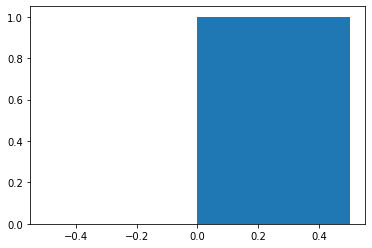

In [15]:
import matplotlib.pyplot as plt
plt.hist(faulty_perc, bins=10, density=True, cumulative=True)

In [16]:
len(faulty_graphs), len(graphs), faulty_nodes, np.mean(faulty_perc)

(0, 411, 0, 0.0)

In [17]:
graphs[list(faulty_graphs)[0]].nodes["C:ASP:80"]

IndexError: list index out of range

In [ ]:
list(graphs[32].nodes)[30:35]

In [ ]:
filenames[32]

In [ ]:
graphs[32].nodes["a:SER:44"]

In [ ]:
for idx in graphs[32].nodes():
    values = graphs[32].nodes[idx]
    #print(values)
    if "chain" not in values.keys():
        print(idx)

In [ ]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
import matplotlib.pyplot as plt
plt.hist([features.shape[0] for features in all_features], bins=20)

In [ ]:
len(all_features), len([features for features in all_features if features.shape[0]<1000])

In [ ]:
#len(protein_ids)

In [18]:
all_adj = [nx.adjacency_matrix(graph) for graph in graphs]

In [19]:
def touches_ligand(x):
    return x <= 4 or (x<=6 and np.random.binomial(1, 1-(x-4)/2) == 1)

class_balance = []
all_targets = []
for graph in graphs:
    targets = np.zeros((graph.number_of_nodes()))
    for i, node_idx in enumerate(graph.nodes):
        distance = graph.nodes[node_idx]["distance"]
        targets[i] = 1 if touches_ligand(distance) else 0
    class_balance.append(targets.sum() / (targets.shape[0]- targets.sum()))
    all_targets.append(targets)

In [20]:
all_adj[0].astype(np.float32)

<501x501 sparse matrix of type '<class 'numpy.float32'>'
	with 2696 stored elements in Compressed Sparse Row format>

In [21]:
# filter and cast to float32 (default for tf)
keep = [features.shape[0]<1000 for features in all_features]
all_features = [features.astype(np.float32) for i, features in enumerate(all_features) if keep[i]]
all_adj = [adj.astype(np.float32) for i, adj in enumerate(all_adj) if keep[i]]
all_targets = [targets.astype(np.float32) for i, targets in enumerate(all_targets) if keep[i]]
protein_groups = [g for i, g in enumerate(protein_groups) if keep[i]]

In [22]:
fair_positive_weight = 1/(sum(class_balance)/len(class_balance))
print("For every non-contact point there are {} contact points".format(
    sum(class_balance)/len(class_balance)))
fair_positive_weight

For every non-contact point there are 0.03551255195059967 contact points


28.15905771545415

## Model

In [23]:
import scipy.sparse as sp
import numpy as np

def sparse_to_tuple(sparse_mx):
    """Convert sparse matrix to tuple representation."""
    def to_tuple(mx):
        if not sp.isspmatrix_coo(mx):
            mx = mx.tocoo()
        coords = np.vstack((mx.row, mx.col)).transpose()
        values = mx.data
        shape = mx.shape
        return coords, values, shape

    if isinstance(sparse_mx, list):
        for i in range(len(sparse_mx)):
            sparse_mx[i] = to_tuple(sparse_mx[i])
    else:
        sparse_mx = to_tuple(sparse_mx)

    return sparse_mx

class Laplacian:
    @staticmethod
    def from_adjacency(adj):
        adj = adj + sp.eye(adj.shape[0])
        """Symmetrically normalize adjacency matrix."""
        adj = sp.coo_matrix(adj)
        rowsum = np.array(adj.sum(1))
        d_inv_sqrt = np.power(rowsum, -0.5).flatten()
        d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
        d_mat_inv_sqrt = sp.diags(d_inv_sqrt)
        return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt).tocoo()


In [24]:
all_adj = [sparse_to_tuple(Laplacian.from_adjacency(adj)) 
            for adj in all_adj]
#all_features = [preprocess_features(sp.lil_matrix(features))
#            for features in all_features]

nb_nodes_per_graph = [adj[2][1] for adj in all_adj]
nb_nodes = max(map(lambda adj: adj[2][1], all_adj))
nb_nodes

999

In [25]:
# Make sparse matrices the same size
for i, adj_tuple in enumerate(all_adj):
    #adj_tuple[2] is the shape, and we want it to be always the same..
    all_adj[i] = (adj_tuple[0], adj_tuple[1], (nb_nodes, nb_nodes))

# Make features the same size as well via padding

for i, features in enumerate(all_features):
    amount = nb_nodes-features.shape[0]
    all_features[i] = np.pad(features, ((0,amount), (0,0)))
    
for i, target in enumerate(all_targets):
    amount = nb_nodes-target.shape[0]
    all_targets[i] = np.pad(target, (0,amount))

masks_all = []
for n in nb_nodes_per_graph:
    mask = np.pad(np.ones(n), (0, nb_nodes - n)).astype(np.float32)
    masks_all.append(mask)

In [26]:
import tensorflow as tf
%load_ext tensorboard
%tensorboard --logdir logs/gradient_tape

/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorboard/compat/tensorflow_stub/dtypes.py:544: FutureWa

Reusing TensorBoard on port 6006 (pid 10092), started 8 days, 4:32:06 ago. (Use '!kill 10092' to kill it.)

In [27]:
import gcn.gcn as gcn
from importlib import reload
reload(gcn)

<module 'gcn.gcn' from '/home/joaquintz/research/thesis/src/gcn/gcn.py'>

### CV model

In [28]:
tf.data.Dataset.from_tensor_slices = lambda a: a 
feats = all_features
supps = [tf.sparse.SparseTensor(indices, values.astype(np.float32), dense_shape)
            for indices, values, dense_shape in all_adj]
targs = all_targets
masks = masks_all

In [29]:
model = gcn.GraphConvolutionalNetwork(all_features[0].shape, 1, all_adj[0][2])

In [30]:
model.fit_cv_groups((feats, supps, targs, masks), protein_groups,
                   positive_weight=34, epochs=40)

Resetting weights..
Start of epoch 0
Epoch 0:
	TRAIN loss 0.71, auc 0.49, recall 0.85, precision 0.04
	VAL loss 0.69 auc 0.46 recall 0.91 precision 0.02
Confusion matrix(TRAIN):
[[16403 99486]
 [  668  3732]]
Confusion matrix(VAL):
[[ 2837 32182]
 [   77   762]]
Start of epoch 1
Epoch 1:
	TRAIN loss 0.70, auc 0.50, recall 0.95, precision 0.04
	VAL loss 0.69 auc 0.47 recall 0.94 precision 0.02
Confusion matrix(TRAIN):
[[  6662 109227]
 [   238   4162]]
Confusion matrix(VAL):
[[ 2615 32404]
 [   51   788]]
Start of epoch 2
Epoch 2:
	TRAIN loss 0.70, auc 0.51, recall 0.96, precision 0.04
	VAL loss 0.69 auc 0.47 recall 0.94 precision 0.02
Confusion matrix(TRAIN):
[[  5186 110703]
 [   187   4213]]
Confusion matrix(VAL):
[[ 2872 32147]
 [   52   787]]
Start of epoch 3
Epoch 3:
	TRAIN loss 0.70, auc 0.53, recall 0.95, precision 0.04
	VAL loss 0.69 auc 0.47 recall 0.88 precision 0.02
Confusion matrix(TRAIN):
[[  7262 108627]
 [   227   4173]]
Confusion matrix(VAL):
[[ 5076 29943]
 [  102   73

Epoch 34:
	TRAIN loss 0.60, auc 0.74, recall 0.72, precision 0.07
	VAL loss 0.62 auc 0.70 recall 0.52 precision 0.05
Confusion matrix(TRAIN):
[[73002 42887]
 [ 1235  3165]]
Confusion matrix(VAL):
[[27034  7985]
 [  405   434]]
Start of epoch 35
Epoch 35:
	TRAIN loss 0.60, auc 0.74, recall 0.72, precision 0.07
	VAL loss 0.61 auc 0.70 recall 0.52 precision 0.05
Confusion matrix(TRAIN):
[[73277 42612]
 [ 1248  3152]]
Confusion matrix(VAL):
[[26986  8033]
 [  401   438]]
Start of epoch 36
Epoch 36:
	TRAIN loss 0.60, auc 0.74, recall 0.72, precision 0.07
	VAL loss 0.61 auc 0.70 recall 0.52 precision 0.05
Confusion matrix(TRAIN):
[[73483 42406]
 [ 1236  3164]]
Confusion matrix(VAL):
[[27142  7877]
 [  402   437]]
Start of epoch 37
Epoch 37:
	TRAIN loss 0.60, auc 0.74, recall 0.72, precision 0.07
	VAL loss 0.61 auc 0.70 recall 0.53 precision 0.05
Confusion matrix(TRAIN):
[[73830 42059]
 [ 1249  3151]]
Confusion matrix(VAL):
[[27021  7998]
 [  398   441]]
Start of epoch 38
Epoch 38:
	TRAIN los

Epoch 28:
	TRAIN loss 0.60, auc 0.73, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.77 recall 0.75 precision 0.08
Confusion matrix(TRAIN):
[[78042 42630]
 [ 1248  2755]]
Confusion matrix(VAL):
[[19152 11084]
 [  303   933]]
Start of epoch 29
Epoch 29:
	TRAIN loss 0.60, auc 0.73, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.77 recall 0.76 precision 0.08
Confusion matrix(TRAIN):
[[77853 42819]
 [ 1236  2767]]
Confusion matrix(VAL):
[[19224 11012]
 [  295   941]]
Start of epoch 30
Epoch 30:
	TRAIN loss 0.60, auc 0.73, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.77 recall 0.75 precision 0.08
Confusion matrix(TRAIN):
[[78304 42368]
 [ 1247  2756]]
Confusion matrix(VAL):
[[19306 10930]
 [  303   933]]
Start of epoch 31
Epoch 31:
	TRAIN loss 0.60, auc 0.73, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.77 recall 0.75 precision 0.08
Confusion matrix(TRAIN):
[[78489 42183]
 [ 1249  2754]]
Confusion matrix(VAL):
[[19363 10873]
 [  304   932]]
Start of epoch 32
Epoch 32:
	TRAIN los

Epoch 22:
	TRAIN loss 0.62, auc 0.73, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.69 recall 0.50 precision 0.08
Confusion matrix(TRAIN):
[[80855 43082]
 [ 1285  2883]]
Confusion matrix(VAL):
[[21092  5879]
 [  538   533]]
Start of epoch 23
Epoch 23:
	TRAIN loss 0.61, auc 0.74, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.70 recall 0.49 precision 0.08
Confusion matrix(TRAIN):
[[81326 42611]
 [ 1288  2880]]
Confusion matrix(VAL):
[[21204  5767]
 [  541   530]]
Start of epoch 24
Epoch 24:
	TRAIN loss 0.61, auc 0.74, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.70 recall 0.50 precision 0.08
Confusion matrix(TRAIN):
[[81822 42115]
 [ 1284  2884]]
Confusion matrix(VAL):
[[21119  5852]
 [  537   534]]
Start of epoch 25
Epoch 25:
	TRAIN loss 0.61, auc 0.74, recall 0.69, precision 0.06
	VAL loss 0.64 auc 0.70 recall 0.50 precision 0.08
Confusion matrix(TRAIN):
[[82194 41743]
 [ 1287  2881]]
Confusion matrix(VAL):
[[21175  5796]
 [  537   534]]
Start of epoch 26
Epoch 26:
	TRAIN los

Epoch 16:
	TRAIN loss 0.63, auc 0.70, recall 0.74, precision 0.05
	VAL loss 0.69 auc 0.69 recall 0.59 precision 0.06
Confusion matrix(TRAIN):
[[63723 54905]
 [ 1066  3037]]
Confusion matrix(VAL):
[[21555 10725]
 [  461   675]]
Start of epoch 17
Epoch 17:
	TRAIN loss 0.62, auc 0.71, recall 0.73, precision 0.05
	VAL loss 0.69 auc 0.70 recall 0.60 precision 0.06
Confusion matrix(TRAIN):
[[65762 52866]
 [ 1088  3015]]
Confusion matrix(VAL):
[[21755 10525]
 [  456   680]]
Start of epoch 18
Epoch 18:
	TRAIN loss 0.62, auc 0.71, recall 0.73, precision 0.06
	VAL loss 0.68 auc 0.70 recall 0.61 precision 0.06
Confusion matrix(TRAIN):
[[67626 51002]
 [ 1114  2989]]
Confusion matrix(VAL):
[[21914 10366]
 [  444   692]]
Start of epoch 19
Epoch 19:
	TRAIN loss 0.61, auc 0.72, recall 0.72, precision 0.06
	VAL loss 0.68 auc 0.70 recall 0.61 precision 0.06
Confusion matrix(TRAIN):
[[69186 49442]
 [ 1140  2963]]
Confusion matrix(VAL):
[[22072 10208]
 [  445   691]]
Start of epoch 20
Epoch 20:
	TRAIN los

Epoch 10:
	TRAIN loss 0.69, auc 0.64, recall 0.74, precision 0.04
	VAL loss 0.63 auc 0.66 recall 0.62 precision 0.05
Confusion matrix(TRAIN):
[[53214 71292]
 [ 1095  3187]]
Confusion matrix(VAL):
[[16180 10222]
 [  367   590]]
Start of epoch 11
Epoch 11:
	TRAIN loss 0.68, auc 0.66, recall 0.74, precision 0.05
	VAL loss 0.62 auc 0.68 recall 0.61 precision 0.06
Confusion matrix(TRAIN):
[[57942 66564]
 [ 1107  3175]]
Confusion matrix(VAL):
[[17523  8879]
 [  375   582]]
Start of epoch 12
Epoch 12:
	TRAIN loss 0.67, auc 0.68, recall 0.74, precision 0.05
	VAL loss 0.61 auc 0.69 recall 0.64 precision 0.06
Confusion matrix(TRAIN):
[[61826 62680]
 [ 1107  3175]]
Confusion matrix(VAL):
[[16574  9828]
 [  342   615]]
Start of epoch 13
Epoch 13:
	TRAIN loss 0.66, auc 0.69, recall 0.74, precision 0.05
	VAL loss 0.60 auc 0.69 recall 0.66 precision 0.06
Confusion matrix(TRAIN):
[[65052 59454]
 [ 1114  3168]]
Confusion matrix(VAL):
[[16058 10344]
 [  323   634]]
Start of epoch 14
Epoch 14:
	TRAIN los

### Train test split

In [ ]:
len(protein_ids), len(all_features)

In [ ]:
protein_ids

In [ ]:
def split_list(data, train_perc, val_perc):
    num_train = int(len(data) * train_perc)
    num_val = int(len(data) * val_perc)
    return data[:num_train], data[num_train:num_train+num_val], data[num_train+num_val:]

features_train, features_val, features_test = split_list(all_features, 0.70, 0.15)
adj_train, adj_val, adj_test = split_list(all_adj, 0.70, 0.15)
y_train, y_val, y_test = split_list(all_targets, 0.70, 0.15)
nodes_train, nodes_val, nodes_test = split_list(nb_nodes_per_graph, 0.70, 0.15)
masks_train, masks_val, masks_test = split_list(masks_all, 0.70, 0.15)

In [ ]:
#%load_ext tensorboard
tf.data.Dataset.from_tensor_slices = lambda a: a 
feats_tr = tf.data.Dataset.from_tensor_slices(features_train)
supps_tr = [tf.sparse.SparseTensor(indices, values.astype(np.float32), dense_shape)
            for indices, values, dense_shape in adj_train]
targs_tr = tf.data.Dataset.from_tensor_slices(y_train)
masks_tr = tf.data.Dataset.from_tensor_slices(masks_train)

feats_vl = tf.data.Dataset.from_tensor_slices(features_val)
supps_vl = [tf.sparse.SparseTensor(indices, values.astype(np.float32), dense_shape)
            for indices, values, dense_shape in adj_val]
targs_vl = tf.data.Dataset.from_tensor_slices(y_val)
masks_vl = tf.data.Dataset.from_tensor_slices(masks_val)


In [ ]:
type(feats_tr[0]), type(supps_tr[0]), type(targs_tr[0]), type(masks_tr[0])

In [ ]:
type(feats[0]), type(supps[0]), type(targs[0]), type(masks[0])

In [ ]:
model = gcn.GraphConvolutionalNetwork(features_train[0].shape, 1, adj_train[0][2])

In [ ]:
model.fit((feats_tr, targs_tr, supps_tr, masks_tr), 
          (feats_vl, targs_vl, supps_vl, masks_vl), 
          epochs=100, positive_weight=34)

In [ ]:
model.weights[0].numpy().sum()

In [ ]:
model.reset_states()

In [ ]:
from sklearn.metrics import roc_auc_score
import numpy as np
all_predicted = []
all_real = []
for x, y, L, mask in zip(feats_vl, targs_vl, supps_vl, masks_vl):
    ỹ = model(x, L)
    ỹ = tf.reshape(ỹ, [-1])
    all_real.append(y)
    all_predicted.append(ỹ.numpy())

real = np.concatenate(all_real)
predicted = np.concatenate(all_predicted)

roc_auc_score(real, predicted)

In [ ]:
from sklearn.metrics import confusion_matrix
pred_classes = np.copy(predicted)
pred_classes[pred_classes > 0.5] = 1
pred_classes[pred_classes <= 0.5] = 0
confusion_matrix(real, pred_classes)

In [ ]:
ỹ

In [ ]:
greater = tf.math.greater(ỹ, 0.5)
tf.cast(tf.math.greater(ỹ, 0.5), tf.int32)  # [1, 2], dtype=tf.int32


In [ ]:
greater

In [ ]:
#

In [ ]:
#tf.Tensor([[0,0],[0,0]])

In [ ]:
model.conf_matrix + tf.math.confusion_matrix(y, ỹ, weights=mask)

In [ ]:
masks_val